# <center> CS559 Homework#3: heart attack prediction classifiers</center>
## <center> Due: 8/6/2021 Friday at 11:59 PM</center>

In this assignment, you are going to implement four classifiers - **decision tree, random forest, adaboost, and gradient boost** - to predict the risk of heart attack. 
For each implementation, 
- no limits on pre-processing and EDA. 
- do not use any outside references - only the lecture note is allowed. 
- must test the accuracy of your algorithm and compare with the built-in classifiers. 
- must evaluate your implementations. 

Here are data attributes:
- Age : Age of the patient
- Sex : Sex of the patient
- exang: exercise induced angina (1 = yes; 0 = no)
- ca: number of major vessels (0-3)
- cp : Chest Pain type chest pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
- trtbps : resting blood pressure (in mm Hg)
- chol : cholestoral in mg/dl fetched via BMI sensor
- fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- restecg : resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- thalach : maximum heart rate achieved
- output : 0= less chance of heart attack 1= more chance of heart attack

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import confusion_matrix
from sklearn import tree as tr
import math
import random as rd
import warnings
warnings.filterwarnings("ignore")

In [2]:
heart = pd.read_csv('heart.csv')

In [3]:
heart

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


### Question 0: EDA and Pre-processing (10 pts)
The EDA and Pre-processing are not limitted however, you must
1. check if the data is **balanced** or not. 
2. check if features are **skewed** or not.
3. check outliers. 

For any finds from 1 to 3, please handle the data carefully. Exaplin your workflow and perform accordingly. If any interesting facts are learned, please state them. 

In [4]:
heart.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object

In [5]:
heart.isnull().sum() / heart.shape[0] * 100.00

age         0.0
sex         0.0
cp          0.0
trtbps      0.0
chol        0.0
fbs         0.0
restecg     0.0
thalachh    0.0
exng        0.0
oldpeak     0.0
slp         0.0
caa         0.0
thall       0.0
output      0.0
dtype: float64

No missing values, no need to worry about imputing missing values.

In [6]:
print("Output:", (heart["output"] == 0).sum(), (heart["output"] == 1).sum())
print("Sex:", (heart["sex"] == 0).sum(), (heart["sex"] == 1).sum())
print("CP:", (heart["cp"] == 0).sum(), (heart["cp"] == 1).sum(), (heart["cp"] == 2).sum(), (heart["cp"] == 3).sum())
print("Chol:", heart["chol"].nlargest(4))
print("FBS:", (heart["fbs"] == 0).sum(), (heart["fbs"] == 1).sum())
print("RestECG:", (heart["restecg"] == 0).sum(), (heart["restecg"] == 1).sum(), (heart["restecg"] == 2).sum())
print("EXNG:", (heart["exng"] == 0).sum(), (heart["exng"] == 1).sum())
print("OldPeak:", heart["oldpeak"].nlargest(4))
print("CAA:", (heart["caa"] == 0).sum(), (heart["caa"] == 4).sum())
print("THALL:", (heart["thall"] == 0).sum(), (heart["thall"] == 1).sum(),
      (heart["thall"] == 2).sum(), (heart["thall"] == 3).sum())


Output: 138 165
Sex: 96 207
CP: 143 50 87 23
Chol: 85     564
28     417
246    409
220    407
Name: chol, dtype: int64
FBS: 258 45
RestECG: 147 152 4
EXNG: 204 99
OldPeak: 204    6.2
221    5.6
291    4.4
101    4.2
Name: oldpeak, dtype: float64
CAA: 175 5
THALL: 2 18 166 117



**Age**: Age appears to be relatively symmetrically distributed with a tendency towards the high-50/low-60 age range.
\
**Sex**: There appears to be over twice as many (207) patients marked as 1 (male) than there are (96) marked as 0 (female).
\
**CP**: A majority (143) of the patients have typical angina, while only 23 are asymptomatic. 50 have atypical angina while 87 have non-anginal pains.
\
**TRTBPS**: Resting blood pressure has a slight right skew with the majority of patients being recorded as around 130 mmHg.
\
**Chol**: Cholesterol is relatively symmetrically distributed, however there is an extreme outlier with one patient having a recorded cholesterol of 564 mg/dl whereas the next highest patients have 417, 409, and 407 mg/dl cholesterol levels.
\
**FBS**: A vast majority (258) of patients have a fasting blood pressure <= 120 mg/dl, while 45 have an fbs > 120 mg/dl.
\
**RestECG**: There are approx. 150 patients with a value that indicates normal, and  approx. 150 having ST-T wave abnormality. However there are also 4 outlier patients showing probable or definite left ventricular hypertrophy by Estes' criteria. 
\
**THALACHH**: The max heart rate achieved shows a left-skewed distribution with a majority of the patients scoring just above 150 bpm.
\
**EXNG**: Over double the patients (204) reported 0, indicating non-exercise induced angina, while 99 reported 1, indicating yes to having exercise induced angina.
\
**OldPeak**: The old peak is clearly right skewed with the vast majority of patients having a recorded oldpeak less than 1, greater than 0. There are also two major outliers, one patient with a 5.6 recorded value, and one with a 6.2.
\
**SLP**: Similarly to RestECG, there are two categories, 1 and 2, that most (approx. 140 each) of the patients fit into, while only about 20 patients have a recorded slp value of 0.
\
**CAA**: CAA is clearly right skewed with 175 patients recording 0 major vessels, while only 5 are recorded with 4 major vessels.
\
**THALL**: The thall values are left skewed, with a majority of patients (166) indicating a value of 2, 117 patients indicating a value of 3, 18 patients indicating a value of 1, and two patients indicating a value of 0.
\
**Output**: The data appears to be **relatively balanced** as shown below with 138 patients marked with 0, indicating they have a smaller chance of heart attack, and 165 patients marked with 1, indicating they have a greater chance of heart attack.

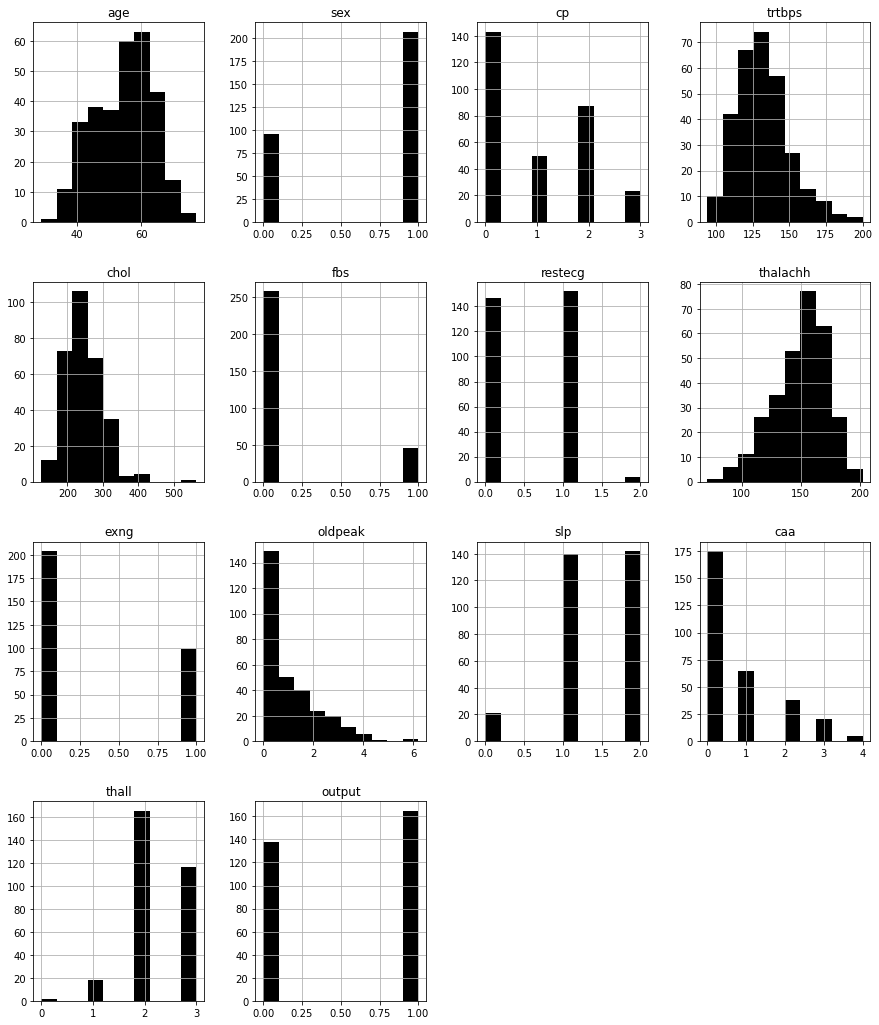

In [7]:
hist = heart.hist(figsize=(15,18), color = 'black')

### Question 1: Decisition Tree Classifier
- DT implementation (10 pts)
- Classification using DecistionTreeClassifier (5 pts)
- Evaluation (5 pts)

In [9]:
X = heart.values[:, 0:13]
y = heart.values[:, 13]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

- DT implementation (10 pts)

Have a function for entropy and information gain. 
Use them to determine the best split. 
Then recursively do step 2 as you split. 

In [10]:
# Calculate the gini index to determine the best candidate for splitting
def giniIndex(groups, output):
    gini = 0
    # First go down split 0, then split 1
    for group in groups:
        if len(group) == 0:
            continue
        score = 0
        for val in output:
            p = [row[-1] for row in group].count(val) / len(group)
            score += p * p
        gini += (1-score) * (len(group) / heart.shape[0])
    return gini

In [11]:
test = heart.values

In [12]:
def tsplit(index,split,column):
    # Split data into two datasets (binary splits only)
    split0, split1 = [], []
    for row in column:
        # Each side grows with values that fit their criteria
        if row[index] < split:
            split0.append(row)
        else:
            split1.append(row)
    return split0, split1

In [13]:
def bestSplit(data):
    # Set high values to satisfy gini < bestScore on first iteration
    bestIdx = 100
    bestValue = 100
    bestScore = 100
    bestGroups = None
    # All columns minus the target
    for index in range(len(data[0])-1):
        for row in data:
            groups = tsplit(index, row[index], data)
            gini = giniIndex(groups,data[:,13])
            # if gini score is better than best so far, set new gini score
            if gini < bestScore:
                bestIdx = index
                bestValue = row[index]
                bestScore = gini
                bestGroups = groups
    return {'index':bestIdx, 'value':bestValue, 'groups':bestGroups}

In [14]:
# Will return the majority result of the output values it has left
def leaf(group):
    tally = [row[-1] for row in group]
    uniques = set(tally)
        #tally up the final row and pick the majority value
    return max(uniques, key=tally.count)

In [15]:
# Create child splits for a node or make terminal
def branch(node, depth):
    left, right = node['groups']
    del(node['groups'])
    
    # check if one of the children is empty
    if not left or not right:
        node['left'] = node['right'] = leaf(left + right)
        return
    
    # check for maximum depth level reached
    if depth == 0:
        node['left'], node['right'] = leaf(left), leaf(right)
        return
    
    # if the group consists of 1 value or less
    if len(left) <= 1:
        # end the branch and make it a leaf
        node['left'] = leaf(left)
    else:
        #else theres enough to continue splitting it
        node['left'] = bestSplit(np.asarray(left))
        branch(node['left'], depth-1)
        
    # do the same for the right child
    if len(right) <= 1:
        node['right'] = leaf(right)
    else:
        #continue splitting
        node['right'] = bestSplit(np.asarray(right))
        branch(node['right'], depth-1)

In [16]:
# Build the decision tree
def buildTree(data,depth):
    root = bestSplit(data)
    branch(root, depth)
    return root

In [17]:
# Make a prediction with a decision tree
def predict(node, row):
    # Traverse down tree
    if row[node['index']] < node['value']:
        # If we are at a parent node
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            #We've hit a terminal node
            return node['left']
    else:
        # If we are at a parent node
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            #We've hit a terminal node
            return node['right']

In [18]:
#Build a tree with depth 2
tree = buildTree(test, 2)

In [19]:
#Get a count for the number of correct predictions
count = 0
for row in test:
    prediction = predict(tree, row)
    if row[-1] == prediction:
        count+=1
print("DT Implementation Accuracy:", count/303)

DT Implementation Accuracy: 0.8448844884488449


- Classification using DecistionTreeClassifier (5 pts)

In [20]:
# Decision Tree
dt = DecisionTreeClassifier()

# fit the model
dt.fit(X_train, y_train)

# make predictions
y_pred = dt.predict(X_test)

# printing the test accuracy
DTAccuracy = accuracy_score(y_test, y_pred)
print("DT Accuracy:", DTAccuracy)

DT Accuracy: 0.7894736842105263


- Evaluation (5 pts)

Although varying, the DT implementation and the built in Decision Tree Classifier both produce roughly equivalent accuracy rates. Both the DT implementation and built-in functions average about 0.80 accuracy, which is much greater than the Zero Rule's accuracy of picking the most popular output, which would be 0.54. I built my tree at depth = 2, though at higher depths, such as at depth = 4, the decision tree's accuracy tends upwards to about a 0.92+ accuracy. As the tree reaches higher depths, it will be much more subject to overfitting, and will likely give worse output accuracies when introduced to new data.

### Question 2: Random Forest Classifier
- RF implementation (10 pts)
- Classification using RandomForestClassifier (5 pts)
- Evaluation (5 pts)

In [21]:
# Split data
X = heart.values[:, 0:13]
y = heart.values[:, 13]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

- RF implementation (10 pts)

In [22]:
# Similar to above decision tree formatting for splitting the tree into different datasets
def tsplit(index,split,column):
    # Split data into two datasets (binary splits only)
    split0, split1 = [], []
    for row in column:
        # Each side grows with values that fit their criteria
        if row[index] < split:
            split0.append(row)
        else:
            split1.append(row)
    return split0, split1

In [23]:
# Select the best split point for the data
def bestSplit(data, numCols):
    features = list()
    #Gather a random number of features up to the number specified
    while len(features) < numCols:
        if data == []:
            continue
        index = rd.randrange(len(data[0])-1)
        # Since picking with replacement, might get duplicate features
        if index not in features:
            features.append(index)
    #Set high initial values so that they can be reset when they hit the if statement below
    bestIdx = 100
    bestValue = 100
    bestScore = 100
    bestGroups = None
    # Now that we have our features, find best split
    for index in features:
        for row in data:
            groups = tsplit(index, row[index], data)
            gini = giniIndex(groups, data[:,13])
            #Update if better split
            if gini < bestScore:
                bestIdx = index
                bestValue = row[index]
                bestScore = gini
                bestGroups = groups
    return {'index':bestIdx, 'value':bestValue, 'groups':bestGroups}

In [24]:
# Will return the majority result of the output values it has left
def leaf(group):
    tally = [row[-1] for row in group]
    uniques = set(tally)
    #tally up the final row and pick the majority value
    return max(uniques, key=tally.count)

In [25]:
# Create branches of the tree
def branch(node, numCols, depth):
    left, right = node['groups']
    del(node['groups'])
    
    # check if one of the children is empty
    if not left or not right:
        node['left'] = node['right'] = leaf(left + right)
        return
    
    # check if maximum depth was reached
    if depth == 0:
        node['left'], node['right'] = leaf(left), leaf(right)
        return
    
    # if the group consists of 1 value or less
    if len(left) <= 1:
        # end the branch and make it a leaf
        node['left'] = leaf(left)
    else:
        #else theres enough to continue splitting it
        node['left'] = bestSplit(np.asarray(left), numCols)
        branch(node['left'], numCols, depth-1)
        
    # do the same for the right child
    if len(right) <= 1:
        node['right'] = leaf(right)
    else:
        #continue splitting
        node['right'] = bestSplit(np.asarray(right), numCols)
        branch(node['right'], numCols, depth-1)

In [26]:
# Build a decision tree
def buildTree(train, numCols):
    root = bestSplit(train, numCols)
    branch(root, numCols, 2)
    return root

In [27]:
# B = 5
tree1 = buildTree(test,4)
tree2 = buildTree(test,4)
tree3 = buildTree(test,4)
tree4 = buildTree(test,4)
tree5 = buildTree(test,4)

In [28]:
# Make a prediction with a decision tree
def predictRF(node, row):
    #Traverse down teh tree
    #Go left if index < value, else go right
    if row[node['index']] < node['value']:
        # If left child is a parent, continue down left
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            #grab teh value of the leaf
            return node['left']
    else:
        #if right child is parent, continue down right
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            #grab the value of the leaf
            return node['right']

In [29]:
#Tally up the total number of correct predictions
count = 0
for row in test:
    prediction = predictRF(tree1, row)+predictRF(tree2, row)+predictRF(tree3, row)+predictRF(tree4, row)+predictRF(tree5, row)
    # if at least 3 trees predicted 1, that holds majority, else at most two predicted 1, and 0 takes majority
    if prediction >= 3:
        prediction = 1
    else:
        prediction = 0
    if row[-1] == prediction:
        count+=1
print("RF Implementation Accuracy:", count/303)

RF Implementation Accuracy: 0.8613861386138614


- Classification using RandomForestClassifier (5 pts)

In [30]:
# Random Forest
rf = RandomForestClassifier()

# fit the model
rf.fit(X_train, y_train)

# make predictions
y_pred = rf.predict(X_test)

# printing the test accuracy
RFAccuracy = accuracy_score(y_test, y_pred)
print("RF Accuracy:", RFAccuracy)

RF Accuracy: 0.8421052631578947


- Evaluation (5 pts)

By taking a multitude of trees, in this case 5, and taking the most commonly predicted value from among them, I am able to make a more accurate prediction from each tree's votes. If a value is widely believed among all the trees, then it has a higher confidence to be correct, and 3 trees need to make incorrect predictions in order for the combined prediction to be wrong. This allows the trees to stay short so that they do not overfit while also reducing variability from using limited information from the data. Both the built in function and the implementation average around 0.85 accuracy, though at higher depths this value climbs as the trees become overfitted to the specific data they were given.

### Question 3: AdaBoost Classifier
- AB implementation (15 pts)
- Classification using AdaBoostClassifier (5 pts)
- Evaluation (5 pts)

In [31]:
#Split the data
X = heart.values[:, 0:13]
y = heart.values[:, 13]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

- AB implementation (15 pts)

In [32]:
# Initialize values for the alphas, predictions at each iteration
alphas = []
predictions = []
# Create an initial weight where every row has the same weight, 1/N
heart['weight'] = 1/heart.shape[0]
heart['weight']

0      0.0033
1      0.0033
2      0.0033
3      0.0033
4      0.0033
        ...  
298    0.0033
299    0.0033
300    0.0033
301    0.0033
302    0.0033
Name: weight, Length: 303, dtype: float64

In [33]:
# T = 5
for i in range(5):
    #Take a random sample
    sample = heart.sample(len(heart), replace = True, weights = heart['weight'])
    
    #X_train and Y_train split
    sampX_train = sample.iloc[:,0:13]
    sampy_train = sample.iloc[:,13]
    
    #Dummy classifier
    dummy = DecisionTreeClassifier(random_state = 100, max_depth=1)
    clf = dummy.fit(sampX_train, sampy_train)
    y_pred = dummy.predict(heart.iloc[:,0:13])
    heart['pred'] = y_pred
    predictions.append(y_pred)
    
    #if the prediction was wrong, set to 1, if it was correct, set to 0
    heart.loc[heart.output != heart.pred, 'wrong'] = 1
    heart.loc[heart.output == heart.pred, 'wrong'] = 0
    
    #calculate the error from the sum of wrong*weight
    e = sum(heart['wrong'] * heart['weight'])
    print("e:",e)
    
    # calculate alpha
    alpha = 0.5*math.log((1-e)/e)
    alphas.append(alpha)
    print("alpha:",alpha)
    
    #calculate the new weight
    new_weight = heart['weight']*np.exp(-1*alpha*heart['output']*heart['pred'])
    #and normalize it
    normalized_weight = new_weight/sum(new_weight)
    heart['weight'] = round(normalized_weight,4)

e: 0.2409240924092413
alpha: 0.5738099338874011
e: 0.27230000000000015
alpha: 0.491492237836663
e: 0.32869999999999994
alpha: 0.35703532513726616
e: 0.2913999999999997
alpha: 0.44429714933513426
e: 0.22609999999999988
alpha: 0.615232643496245


In [34]:
# Show values being used in calculation
print(alphas)
print(predictions)

[0.5738099338874011, 0.491492237836663, 0.35703532513726616, 0.44429714933513426, 0.615232643496245]
[array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 

In [35]:
#final prediction
t=0
for i in range(5):
    t += alphas[i] * predictions[i]

for i in range(len(t)):
    #if values get too high (say all 5 predictions predict 1), reset to 1
    if t[i] >=2:
        t[i]=1
t = t.astype(int)
#our result
t

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,

In [36]:
#Tally total number of correct predictions
count = 0
for i in range(len(t)):
    if t[i] == heart['output'][i]:
        count+=1
print("AdaBoost Implementation:", count/303)

AdaBoost Implementation: 0.834983498349835


- Classification using AdaBoostClassifier (5 pts)

In [37]:
# Ada Boost
ada = AdaBoostClassifier()

# fit the model
ada.fit(X_train, y_train)

# make predictions
y_pred = ada.predict(X_test)

# printing the test accuracy
ADAAccuracy = accuracy_score(y_test, y_pred)
print("ADA Accuracy:", ADAAccuracy)

ADA Accuracy: 0.8421052631578947


- Evaluation (5 pts)

The Ada Boost Implementation provides an accuracy of around 0.76 - 0.84, which is somehwat lower than the built-ins average around 0.84, though not significantly so. The weights for adaptive boosting are recomputed iteratively and combines rougher, weaker classifiers to create a combined prediction similarly to random forest. It creates multiple dummy classifiers and uses a combination of their predicted results and weights based on their alphas to try and come up with a more accurate final result. This is because the more accurate iterations have higher alpha values and thus get weighted heavier in the final calculation. However, since none do extremely well, the AdaBoost still reports relatively low numbers. This can be improved by using more accurate weak classifiers.

### Question 4: Gradient Boost Classifier
- GB implementation (15 pts)
- Classification using GradientBoostingClassifier (5 pts)
- Evaluation (5 pts)

In [38]:
#Split the data
X = heart.values[:, 0:13]
y = heart.values[:, 13]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

- GB implementation (15 pts)

In [39]:
# Log Odds is log(proportion of 1s to 0s)
logOdds = math.log((heart["output"] == 1).sum()/(heart["output"] == 0).sum())
#initial prediction
heart["logOdds"] = logOdds
#initial probability
p1 = np.exp(logOdds)/(1+np.exp(logOdds))
#initialize additional columns i'll be using
heart["prediction"] = p1
heart["residual"] = 0.0
heart["resPred"] = 0.0
heart["outputVal"] = 0.0

In [40]:
# T = 5
for i in range(5):
    #Calculate residual
    heart["residual"] = heart["output"] - heart["prediction"]

    #Dummy regressor
    dummy = DecisionTreeRegressor(max_leaf_nodes = 8)
    testX = heart.values[:,0:13]
    testy = heart["residual"]
    clf = dummy.fit(testX,testy)
    y_pred = dummy.predict(testX)
    heart['resPred'] = y_pred
    leaves = heart['resPred'].unique()
    
    # calculate outputValues
    for i in range(8):
        group = heart[heart["resPred"]==leaves[i]]
        residual = group.residual.sum()
        prevProb = 0
        for r in group.residual:
            prevProb += p1*(1-p1)
        outputVal = residual/prevProb
        for j in group.index:
            heart.at[j,"outputVal"] = outputVal
            
    # logOdds = logOdds + .1*outputVal
    heart["logOdds"] = heart["logOdds"] + 0.1 * heart["outputVal"]
    heart["prediction"] = np.exp(heart["logOdds"])/(1+np.exp(heart["logOdds"]))

In [41]:
heart["finalPred"] = (heart["prediction"] + 0.5).astype(int)

In [42]:
heart

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,...,output,weight,pred,wrong,logOdds,prediction,residual,resPred,outputVal,finalPred
0,63,1,3,145,233,1,0,150,0,2.3,...,1,0.0008,0,1.0,0.711168,0.670659,0.353820,0.270037,1.088794,1
1,37,1,2,130,250,0,1,187,0,3.5,...,1,0.0008,0,1.0,0.687630,0.665440,0.314491,-0.227127,-0.915779,1
2,41,0,1,130,204,0,0,172,0,1.4,...,1,0.0008,0,1.0,0.790522,0.687943,0.335895,0.270037,1.088794,1
3,56,1,1,120,236,0,1,178,0,0.8,...,1,0.0008,0,1.0,0.613602,0.648762,0.376432,0.270037,1.088794,1
4,57,0,0,120,354,0,1,163,1,0.6,...,1,0.0015,0,1.0,0.441107,0.608523,0.417699,0.270037,1.088794,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,...,0,0.0056,0,0.0,-0.035582,0.491105,-0.503595,-0.123912,-0.499614,0
299,45,1,3,110,264,0,1,132,0,1.2,...,0,0.0056,0,0.0,-0.006724,0.498319,-0.507934,-0.095397,-0.384644,0
300,68,1,0,144,193,1,1,141,0,3.4,...,0,0.0056,0,0.0,-0.636052,0.346140,-0.382760,-0.392370,-1.582040,0
301,57,1,0,130,131,0,1,115,1,1.2,...,0,0.0056,0,0.0,-0.636052,0.346140,-0.382760,-0.392370,-1.582040,0


In [43]:
count = 0
for i in range(len(heart["finalPred"])):
    if heart["finalPred"][i] == heart['output'][i]:
        count+=1
print("GradBoost Implementation:",count/303)

GradBoost Implementation: 0.8745874587458746


- Classification using GradientBoostingClassifier (5 pts)

In [44]:
# Gradient Boost
gr = GradientBoostingClassifier()

# fit the model
gr.fit(X_train, y_train)

# make predictions
y_pred = gr.predict(X_test)

# printing the test accuracy
GRAccuracy = accuracy_score(y_test, y_pred)
print("Grad Boosting Accuracy:", GRAccuracy)

Grad Boosting Accuracy: 0.8026315789473685


- Evaluation (5 pts)

After 5 iterations of the Gradient Boosting implementation (to keep consistent with the other classifiers), it achieved an accuracy averaging around 0.87, compared to the builtin classifier averaging about 0.80. This is the most accurate result out of all the classifiers, and since Gradient Boosting is pretty robust against overfitting, the number of iterations run can increase dramatically from 5 to improve performance even further without becoming too vulnerable to overfitting. It consistently outperforms the other classifiers and is consistently reporting a 0.87 accuracy.